In [32]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# data here is just an example. code copied from Aaryan's notebook
def kraken_api_data(symbol, timeframe, extract):

  # Fetch OHLCV data from Kraken
  url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'

  # Make the API request
  response = requests.get(url)
  data = response.json()

  # Extract OHLCV data
  ohlc_data = data['result'][extract]

  # Convert the data to a DataFrame
  columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'wavg price', 'count']
  df = pd.DataFrame(ohlc_data, columns=columns)

  # Convert Unix timestamp to datetime format
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

  # Convert 'open', 'high', 'low', 'close', 'volume', 'wavg_price' to numeric type
  string_columns = ['open', 'high', 'low', 'close', 'volume', 'wavg price']
  df[string_columns] = df[string_columns].apply(pd.to_numeric, errors='coerce')
  df.set_index('timestamp', inplace = True)

  return df

<Axes: xlabel='timestamp'>

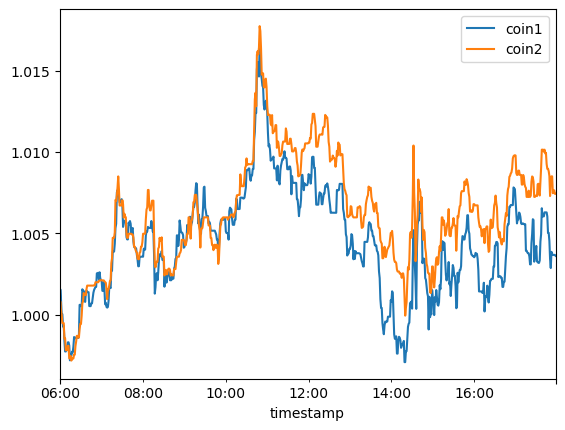

In [34]:
timeframe = "1"
eth_df = kraken_api_data("ETHUSD",timeframe,"XETHZUSD")
btc_df = kraken_api_data("BTCUSD",timeframe,"XXBTZUSD")

df = pd.DataFrame({"coin1" : eth_df['close'], "coin2" : btc_df['close']})

# normalise the data by dividing by a rolling average
df['coin1'] /= df['coin1'].iloc[0]
df['coin2'] /= df['coin2'].iloc[0]
df = df.dropna()

df.plot()

In [35]:
def ols_reg(coin1, coin2):
    #  analytical formula for OLS regression
    coin1_bar = np.mean(coin1)
    coin2_bar = np.mean(coin2)
    beta = np.sum((coin1 - coin1_bar) * (coin2 - coin2_bar))/ np.sum((coin1 - coin1_bar)**2)
    intercept = coin2_bar - beta*coin1_bar
    return beta, intercept


In [36]:
# set up a static hedge and compute residuals
df['beta static'] = ols_reg(df['coin1'], df['coin2'])[0]
df['coint port static'] = df['coin2'] - df['beta static']*df['coin1']
df['static residuals'] = df['coint port static'] - ols_reg(df['coin1'], df['coin2'])[1]

# set up a dynamic hedge and compute residuals
lookback = 100
df['beta dynamic'] = np.nan
df['dynamic intercept'] = np.nan
for t in range(lookback, df.count()[0]):
    df.iloc[t,5], df.iloc[t,6] = ols_reg(df['coin1'].iloc[t - lookback:t], df['coin2'].iloc[t - lookback: t])


df['coint port dynamic'] = df['coin2'] - df['beta dynamic']*df['coin1']
df['dynamic residuals'] = df['coint port dynamic'] - df['dynamic intercept']
del df['dynamic intercept']

df = df.dropna()
df.head()

,coin1,coin2,beta static,coint port static,static residuals,beta dynamic,coint port dynamic,dynamic residuals
timestamp,,,,,,,,
2024-01-24 07:39:00,1.005663,1.004980,0.935414,0.064268,-0.002354,1.057510,-0.058519,-0.001064
2024-01-24 07:40:00,1.005560,1.004982,0.935414,0.064367,-0.002255,1.051867,-0.052733,-0.000921
2024-01-24 07:41:00,1.005762,1.004980,0.935414,0.064176,-0.002447,1.047184,-0.048238,-0.001116
2024-01-24 07:42:00,1.005596,1.004982,0.935414,0.064334,-0.002289,1.040812,-0.041654,-0.000912
2024-01-24 07:43:00,1.005025,1.004980,0.935414,0.064865,-0.001757,1.036271,-0.036499,-0.000298


<Axes: xlabel='timestamp'>

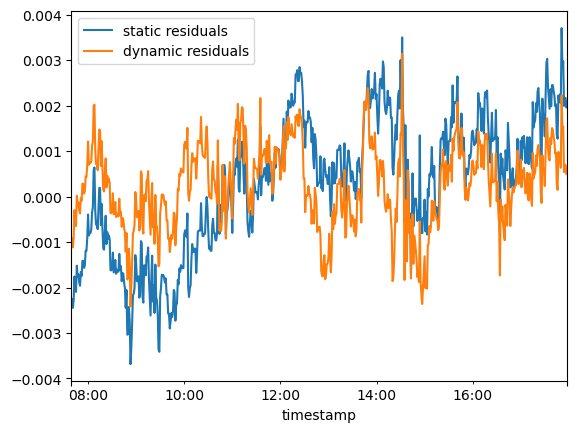

In [37]:
df[['static residuals', 'dynamic residuals']].plot()

In [7]:
# need more/better data to make conclusions about dynamic hedging but the residuals look slightly better.

<Axes: xlabel='timestamp'>

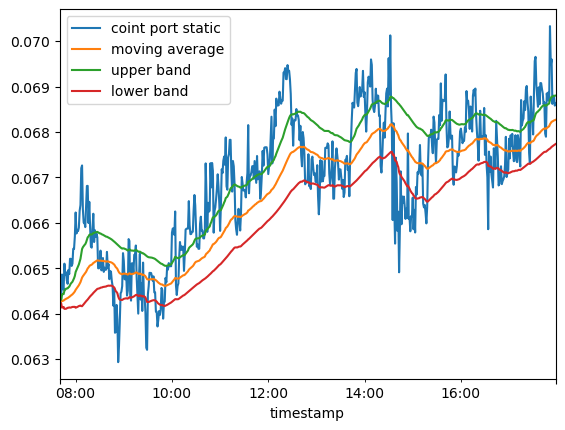

In [38]:
# I have only used the statically hedged portfolio here since the dynamic one behaves weirdly with small amounts of data
df2 = df[['coin1', 'coin2', 'coint port static']].copy()

# compute exponentially weighted moving average and sd
a=0.02
df2['moving average'] = df2['coint port static'].ewm(alpha=a, adjust=False).mean()
df2['moving std'] = df2['coint port static'].ewm(alpha=a, adjust=False).std()
df2=df2.dropna()

# entry and exit points
enter_std = 0.65
exit_std = 0.1

df2['upper band'] = df2['moving average'] + enter_std * df2['moving std']
df2['lower band'] = df2['moving average'] - enter_std * df2['moving std']


df2[['coint port static', 'moving average', 'upper band', 'lower band']].plot()

In [39]:
# strategy signal generation
df2['long signal'] = np.where(df2['coint port static'] < df2['lower band'], 1, 0)
df2['short signal'] = np.where(df2['coint port static'] > df2['upper band'], -1, 0)
df2['exit signal'] = np.where((df2['coint port static'] < df2['moving average'] + df2['moving std'] * exit_std) &
                                      (df2['coint port static'] > df2['moving average'] - df2['moving std'] * exit_std)
                                      , 1, 0)

# Combine signals to determine positions
df2['position'] = 0
df2.loc[df2['long signal'] == 1, 'position'] = 1
df2.loc[df2['short signal'] == -1, 'position'] = -1

# Forward fill to maintain positions until the next signal
df2['position'] = df2['position'].replace(to_replace=0, method='ffill')

# Use exit position to remove trades when required
df2.loc[df2['exit signal'] == 1, 'position'] = 0


<Axes: xlabel='timestamp'>

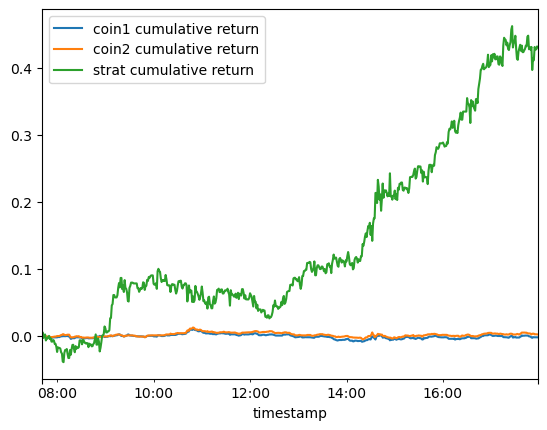

In [40]:
# Measuring results of our strategy

# we shift the position by one to remove forward bias
df2['position'] = df2['position'].shift(1)

# daily returns calculation
df2['coint return'] = df2['coint port static'].pct_change()
df2["coin1 return"] = df2['coin1'].pct_change()
df2["coin2 return"] = df2['coin2'].pct_change()
df2.dropna(inplace = True)
df2["strat return"] = df2["coint return"] * df2['position']

# cumulative returns calculation
df2['coin1 cumulative return'] = (1 + df2['coin1 return']).cumprod() - 1
df2['coin2 cumulative return'] = (1 + df2['coin2 return']).cumprod() - 1
df2['strat cumulative return'] = (1 + df2['strat return']).cumprod() - 1
df2[['coin1 cumulative return', 'coin2 cumulative return', 'strat cumulative return']].plot()